In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates

from xfrites.conn.conn_spec  import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Loading data

In [3]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '141017', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1]).isel(trials=slice(0,20))

In [4]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, verbose=True) 

100%|██████████| 82/82 [00:00<00:00, 1057.99it/s]


#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [5]:
channel_labels = np.array([12, 17, 18, 181, 69,104,95,106])

In [6]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where( data.attrs["channels_labels"]==c )[0][0]]

In [7]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [8]:
pairs = np.array([[6,11],
                  [11,12],
                  [11,65],
                  [30,39],
                  [36,41]])

### Spectral analysis

#### Define parameters

In [24]:
# Smoothing windows

#sm_times  = 0.3
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [4, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)

n_cy      = 0.05
n_cycles  = 7.#freqs/2
sm_times  = 0.3

In [25]:
kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=pairs,
    mode=mode, n_cycles=n_cycles, decim=decim, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=1, bias_correction=True,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   11.2s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   16.3s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   16.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

bias=array([0.74468085, 0.67759779, 0.62160203, 0.57415467, 0.53343701,
       0.49811211, 0.46717516, 0.43985637, 0.41555609, 0.39380023,
       0.37420903, 0.35647475, 0.34034531, 0.3256123 , 0.31210191,
       0.29966801, 0.28818686, 0.277553  , 0.26767598, 0.25847777,
       0.24989072, 0.24185587, 0.23432163, 0.22724261, 0.22057878,
       0.21429464, 0.20835864, 0.20274264, 0.19742143, 0.19237241,
       0.18757519, 0.18301142, 0.17866444, 0.17451918, 0.17056191,
       0.16678012, 0.1631624 , 0.1596983 , 0.15637823, 0.15319339,
       0.15013569, 0.14719767, 0.14437242, 0.14165359, 0.13903527,
       0.13651198, 0.13407865, 0.13173055, 0.12946327, 0.12727273])


In [26]:
# compute the coherence
coh_surr = conn_spec(data_surr, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   17.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   17.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

bias=array([0.74468085, 0.67759779, 0.62160203, 0.57415467, 0.53343701,
       0.49811211, 0.46717516, 0.43985637, 0.41555609, 0.39380023,
       0.37420903, 0.35647475, 0.34034531, 0.3256123 , 0.31210191,
       0.29966801, 0.28818686, 0.277553  , 0.26767598, 0.25847777,
       0.24989072, 0.24185587, 0.23432163, 0.22724261, 0.22057878,
       0.21429464, 0.20835864, 0.20274264, 0.19742143, 0.19237241,
       0.18757519, 0.18301142, 0.17866444, 0.17451918, 0.17056191,
       0.16678012, 0.1631624 , 0.1596983 , 0.15637823, 0.15319339,
       0.15013569, 0.14719767, 0.14437242, 0.14165359, 0.13903527,
       0.13651198, 0.13407865, 0.13173055, 0.12946327, 0.12727273])


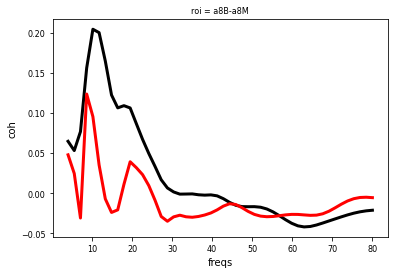

In [27]:
coh.sel(times=slice(0,3.0)).isel(roi=0).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=0).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="r", lw=3);

In [15]:
sm_times

0.3

In [28]:
np.ones((4,4,10,4))*a[None,None,:,None]

array([[[[6.64218590e-04, 6.64218590e-04, 6.64218590e-04,
          6.64218590e-04],
         [9.41667795e-01, 9.41667795e-01, 9.41667795e-01,
          9.41667795e-01],
         [2.78325298e-01, 2.78325298e-01, 2.78325298e-01,
          2.78325298e-01],
         [1.85897603e-01, 1.85897603e-01, 1.85897603e-01,
          1.85897603e-01],
         [6.91508108e-01, 6.91508108e-01, 6.91508108e-01,
          6.91508108e-01],
         [1.08903739e-01, 1.08903739e-01, 1.08903739e-01,
          1.08903739e-01],
         [2.64649598e-01, 2.64649598e-01, 2.64649598e-01,
          2.64649598e-01],
         [9.75094680e-01, 9.75094680e-01, 9.75094680e-01,
          9.75094680e-01],
         [6.39462774e-01, 6.39462774e-01, 6.39462774e-01,
          6.39462774e-01],
         [5.20677791e-01, 5.20677791e-01, 5.20677791e-01,
          5.20677791e-01]],

        [[6.64218590e-04, 6.64218590e-04, 6.64218590e-04,
          6.64218590e-04],
         [9.41667795e-01, 9.41667795e-01, 9.41667795e-01,
     

In [22]:
b[0,0,]

0.9416677953897564

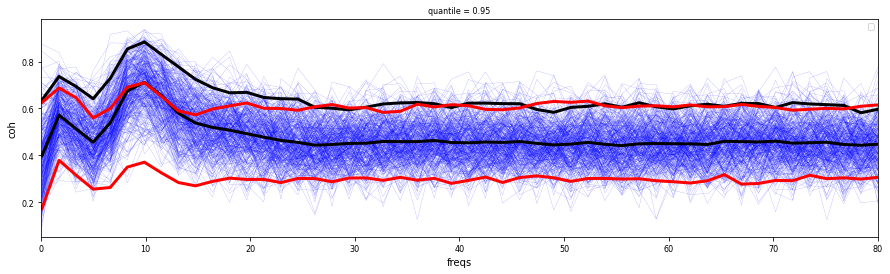

In [30]:
plt.figure(figsize=(15,4))
coh.sel(times=slice(0.5,2.0)).isel(roi=1).mean("times").plot.line(x="freqs", hue="trials", color="b", lw=0.1);
coh.sel(times=slice(0.5,2.0)).isel(roi=1).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh.sel(times=slice(0.5,2.0)).isel(roi=1).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=1).mean("times").quantile(0.05,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=1).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
plt.xlim(0, 80)
plt.legend([])

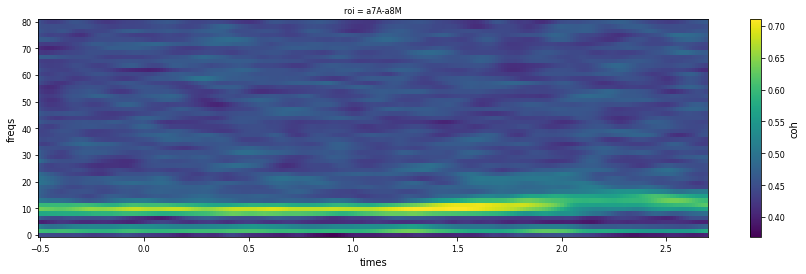

In [31]:
plt.figure(figsize=(15,4))
coh.mean("trials").isel(roi=2).sel(times=slice(-0.5,2.7)).plot(x="times", y="freqs")

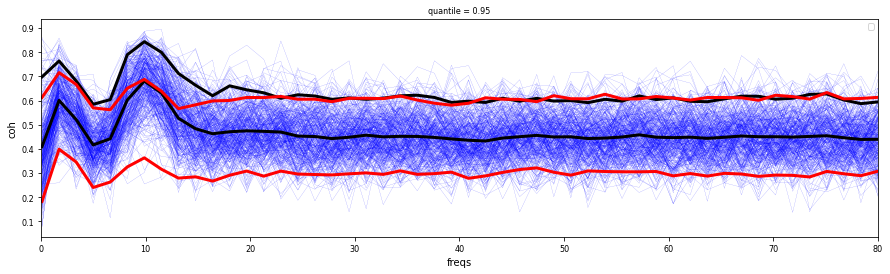

In [32]:
plt.figure(figsize=(15,4))
coh.sel(times=slice(0.5,2.0)).isel(roi=2).mean("times").plot.line(x="freqs", hue="trials", color="b", lw=0.1);
coh.sel(times=slice(0.5,2.0)).isel(roi=2).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh.sel(times=slice(0.5,2.0)).isel(roi=2).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=2).mean("times").quantile(0.05,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=2).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
plt.xlim(0, 80)
plt.legend([])

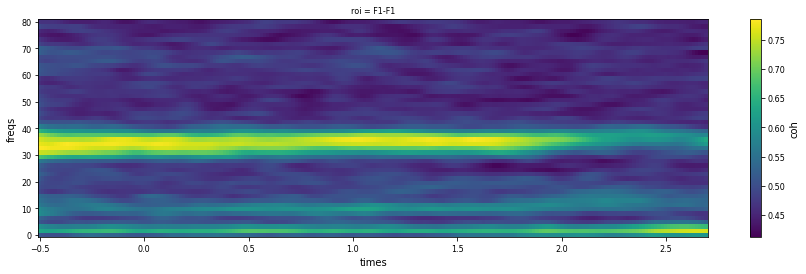

In [33]:
plt.figure(figsize=(15,4))
coh.mean("trials").isel(roi=3).sel(times=slice(-0.5,2.7)).plot(x="times", y="freqs")

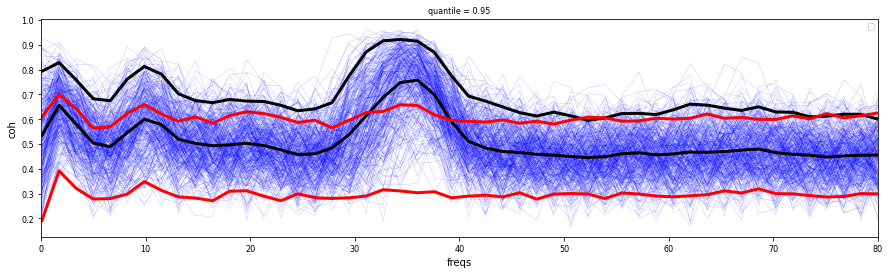

In [34]:
plt.figure(figsize=(15,4))
coh.sel(times=slice(0.5,2.0)).isel(roi=3).mean("times").plot.line(x="freqs", hue="trials", color="b", lw=0.1);
coh.sel(times=slice(0.5,2.0)).isel(roi=3).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh.sel(times=slice(0.5,2.0)).isel(roi=3).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=3).mean("times").quantile(0.05,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=3).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
plt.xlim(0, 80)
plt.legend([])

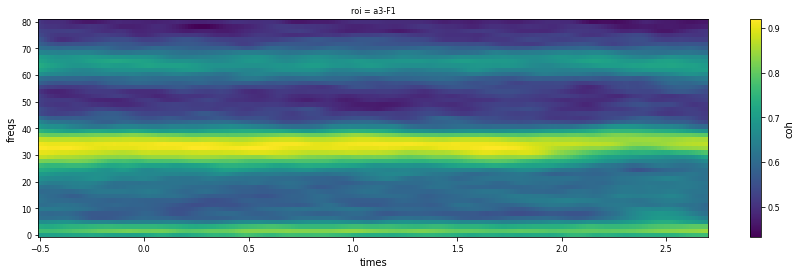

In [35]:
plt.figure(figsize=(15,4))
coh.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.7)).plot(x="times", y="freqs")

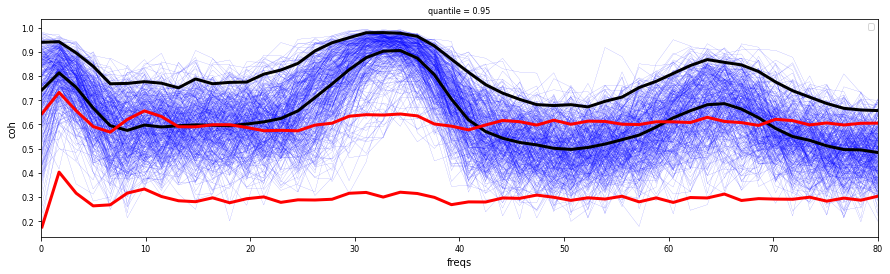

In [36]:
plt.figure(figsize=(15,4))
coh.sel(times=slice(0.5,2.0)).isel(roi=4).mean("times").plot.line(x="freqs", hue="trials", color="b", lw=0.1);
coh.sel(times=slice(0.5,2.0)).isel(roi=4).mean("times").mean("trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh.sel(times=slice(0.5,2.0)).isel(roi=4).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="k", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=4).mean("times").quantile(0.05,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
coh_surr.sel(times=slice(0.5,2.0)).isel(roi=4).mean("times").quantile(0.95,"trials").plot.line(x="freqs", hue="trials", color="r", lw=3);
plt.xlim(0, 80)
plt.legend([])

In [37]:
eta = xr.DataArray( np.random.normal(0,1,size=(332,10,3650)), dims=data.dims, coords={"trials":data.trials.values, "time": data.time.values})

In [22]:
# define temporal windows + compute the DFC
n_cycles = freqs/2.

kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=-1, pairs=None,
    mode=mode, n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=4
)

# compute the coherence
coh_eta = conn_spec(eta, **kw)

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   14.8s remaining:    6.3s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   19.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...165 : 0/45 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   10.9s remaining:   16.4s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   15.7s remaining:    6.7s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   20.6s finished


  0%|          | Estimating pairwise Coherence for trials 166...331 : 0/45 [00:00<?,       ?it/s]

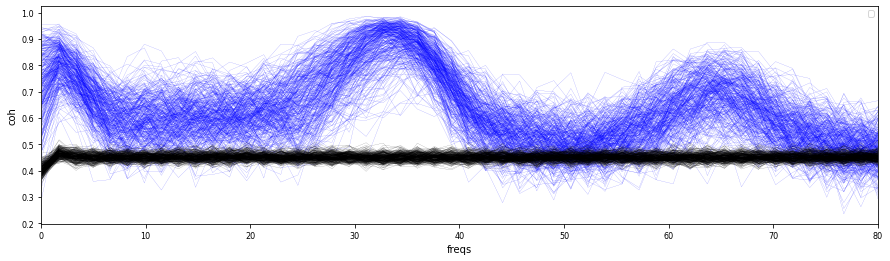

In [24]:
plt.figure(figsize=(15,4))
coh.sel(times=slice(-0.5,2.7)).isel(roi=4).mean("times").plot.line(x="freqs", hue="trials", color="b", lw="0.1",);
coh_eta.sel(times=slice(-0.5,2.7)).mean("roi").mean("times").plot.line(x="freqs", hue="trials", color="k", lw="0.1",);
plt.xlim(0, 80)
plt.legend([])

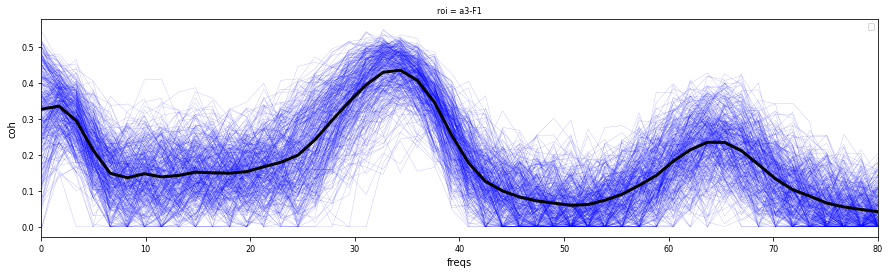

In [25]:
plt.figure(figsize=(15,4))
aux = coh.isel(roi=4).mean("times")-coh_eta.mean("roi").mean("times")
aux = aux * (aux>=0)
aux.plot.line(x="freqs", hue="trials",  color="b", lw=0.1);
plt.plot(aux.freqs, aux.mean("trials"), color="k", lw=3);
plt.xlim(0, 80)
plt.legend([])

In [26]:
B = coh_eta.mean("roi")

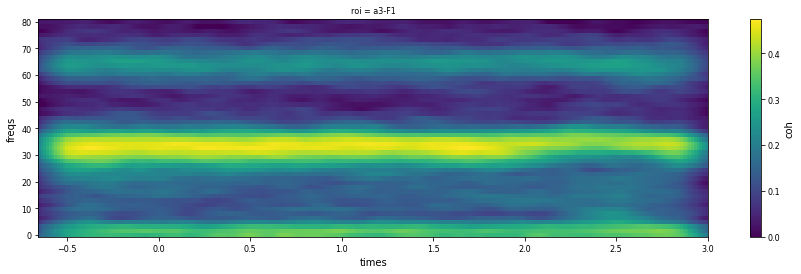

In [27]:
plt.figure(figsize=(15,4))
aux = coh.mean("trials").isel(roi=4) - B.mean("trials")
#aux = coh.isel(roi=4,trials=100) - B.isel(trials=100)
aux = aux * (aux>=0)
aux.plot(x="times", y="freqs")

In [101]:
sm_times = np.arange(0.1, 1.1, 0.1)

freqs    = np.linspace(1, 80, n_freqs, endpoint=True)

# define temporal windows + compute the DFC
n_cycles = freqs/2

kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=-1, pairs=None, 
    mode=mode, n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel=sm_kernel,
    sm_freqs=sm_freqs, block_size=1
)

eta = xr.DataArray( np.random.normal(0,1,size=(332,10,3650)), 
                    dims=data.dims, coords={"trials":data.trials.values, "time": data.time.values})

coh_eta = []
for sm in sm_times:
    # compute the coherence
    kw["sm_times"] = sm
    coh_eta += [conn_spec(eta, **kw)]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=7, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:    8.5s remaining:    3.7s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    8.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:    9.7s remaining:    4.2s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   10.1s remaining:   15.2s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   10.5s remaining:    4.5s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=27, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   10.8s remaining:    4.6s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   11.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=33, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   11.1s remaining:   16.7s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   11.4s remaining:    4.9s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   11.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=40, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   12.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=47, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   12.4s remaining:   18.5s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   13.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=53, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   13.5s remaining:    5.8s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   13.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=60, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   13.7s remaining:   20.6s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   14.1s remaining:    6.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   14.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=45, n_freqs=50, decim=15, sm_times=67, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  10 | elapsed:   14.3s remaining:   21.5s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:   14.6s remaining:    6.3s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   15.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/45 [00:00<?,       ?it/s]

In [65]:
B      = []
B_anal = [] 
for i in range( len(coh_eta) ):
    B += [ coh_eta[i].mean().values ]
    B_anal += [1/(1+4*sm_times[i])]

In [102]:
B      = []
B_anal = [] 
for i in range( len(coh_eta) ):
    B += [ coh_eta[i].mean(dim=("roi","times","trials")) ]
    B_anal += [ (1+2*(sm_times[i]*freqs)/n_cycles)**-1 ]

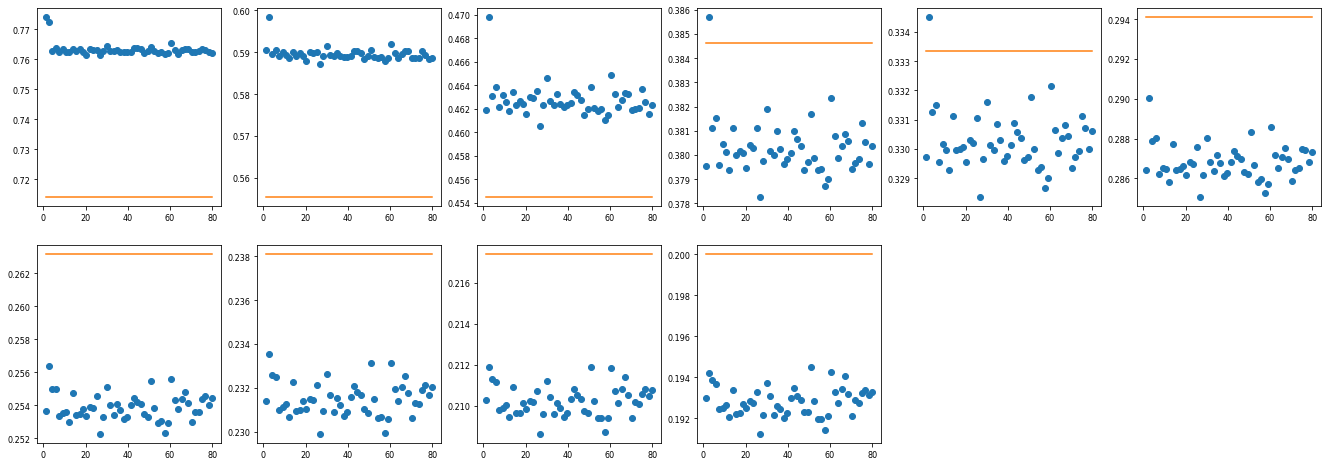

In [103]:
plt.figure(figsize=(23,8))
for i in range(len(sm_times)):
    plt.subplot(2,6,i+1)
    plt.plot(freqs, B[i], "o")
    plt.plot(freqs, B_anal[i], "-")

In [104]:
B      = []
B_anal = [] 
for i in range( len(coh_eta) ):
    B += [ coh_eta[i].mean() ]
    B_anal += [ np.mean((1+2*(sm_times[i]*freqs)/n_cycles)**-1) ]

Text(0.5, 0, 'sm_times [s]')

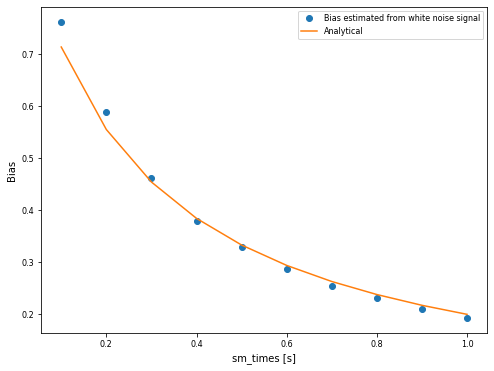

In [105]:
plt.figure(figsize=(8,6,))
plt.plot(sm_times, B, "o")
plt.plot(sm_times, B_anal, "-")
plt.legend(["Bias estimated from white noise signal", "Analytical"])
plt.ylabel("Bias")
plt.xlabel("sm_times [s]")

In [59]:
coh_eta[0].mean(dim=("roi","times","trials"))

<xarray.DataArray 'coh' (freqs: 50)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Coordinates:
  * freqs    (freqs) float64 1.0 2.612 4.224 5.837 ... 75.16 76.78 78.39 80.0

### Bias of the metric

In [126]:
eta = xr.DataArray( np.random.normal(0,1,size=(1,30,3650)), 
                    dims=data.dims, 
                   coords={"time": np.arange(n)/sfreq})

In [135]:
# define temporal windows + compute the DFC
n_cycles = freqs/2.

freqs    = np.linspace(10,100,50)
n_cy     = np.linspace(1, 40, 20)

kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode=mode, n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel=sm_kernel,
    sm_freqs=sm_freqs, block_size=1
)

coh_eta = []

for i in range( len(n_cy) ):
    kw["sm_times"] = n_cy[i]/freqs
    # compute the coherence
    coh_eta += [conn_spec(eta, **kw)]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[100  84  73  64  57  52  47  43  40  37  35  33  31  29  28  26  25  24
  23  22  21  20  19  19  18  17  17  16  16  15  15  14  14  14  13  13
  13  12  12  12  11  11  11  11  11  10  10  10  10  10], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[305 257 223 196 175 159 145 133 123 115 107 101  95  90  85  81  77  74
  70  67  65  62  60  58  56  54  52  51  49  48  46  45  44  43  42  41
  40  39  38  37  36  35  35  34  33  32  32  31  31  30], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[510 431 373 329 294 266 242 223 206 192 179 169 159 150 142 135 129 123
 118 113 109 105 101  97  94  91  88  85  83  80  78  76  74  72  70  68
  67  65  63  62  61  59  58  57  56  55  54  52  52  51], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[715 604 523 461 412 373 340 313 289 269 252 236 223 211 200 190 181 173
 166 159 153 147 141 137 132 128 123 120 116 113 109 106 104 101  98  96
  94  91  89  87  85  83  82  80  78  77  75  74  72  71], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[921 778 673 593 530 480 438 402 372 347 324 304 287 271 257 245 233 223
 213 205 197 189 182 176 170 164 159 154 149 145 141 137 133 130 127 123
 120 118 115 112 110 107 105 103 101  99  97  95  93  92], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[1126  951  823  726  649  587  535  492  456  424  397  372  351  332
  315  299  285  273  261  250  241  231  223  215  208  201  195  189
  183  178  173  168  163  159  155  151  147  144  141  137  134  132
  129  126  124  121  119  116  114  112], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[1331 1124  973  858  767  694  633  582  539  501  469  440  415  393
  372  354  338  323  309  296  284  274  264  254  246  238  230  223
  216  210  204  198  193  188  183  179  174  170  166  163  159  156
  152  149  146  143  140  138  135  133], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[1536 1298 1123  990  885  801  731  672  622  579  541  508  479  453
  430  409  390  372  356  342  328  316  304  294  284  274  266  257
  250  242  236  229  223  217  212  206  201  197  192  188  184  180
  176  172  169  165  162  159  156  153], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[1742 1471 1274 1123 1004  908  828  762  705  656  614  576  543  514
  487  463  442  422  404  388  372  358  345  333  322  311  301  292
  283  275  267  260  253  246  240  234  228  223  218  213  208  204
  199  195  191  188  184  180  177  174], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[1947 1645 1424 1255 1122 1015  926  851  788  734  686  644  607  574
  545  518  494  472  452  433  416  400  386  372  360  348  337  326
  317  307  299  290  283  275  268  262  255  249  244  238  233  228
  223  218  214  210  206  202  198  194], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[2152 1818 1574 1387 1240 1122 1024  941  871  811  758  712  671  635
  602  573  546  522  499  479  460  443  427  412  398  384  372  361
  350  340  330  321  312  304  297  289  282  276  269  263  257  252
  247  241  237  232  227  223  219  215], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[2357 1992 1724 1520 1359 1229 1121 1031  954  888  831  780  735  696
  660  627  598  571  547  525  504  485  467  451  435  421  408  395
  383  372  362  352  342  333  325  317  309  302  295  288  282  276
  270  264  259  254  249  244  240  235], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[2563 2165 1874 1652 1477 1336 1219 1121 1037  966  903  848  799  756
  717  682  650  621  595  570  548  527  508  490  473  458  443  430
  417  405  393  382  372  362  353  345  336  328  321  313  307  300
  294  288  282  276  271  266  261  256], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[2768 2338 2024 1784 1595 1443 1317 1211 1121 1043  975  916  864  817
  775  737  702  671  642  616  592  569  549  529  511  495  479  464
  450  437  425  413  402  392  382  372  363  355  346  339  331  324
  317  311  304  298  292  287  282  276], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[2973 2512 2174 1917 1714 1550 1414 1300 1204 1120 1048  984  928  877
  832  791  754  721  690  662  636  612  589  569  549  531  514  499
  484  470  456  444  432  421  410  400  390  381  372  364  356  348
  341  334  327  320  314  308  302  297], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[3178 2685 2324 2049 1832 1657 1512 1390 1287 1198 1120 1052  992  938
  890  846  807  771  738  708  680  654  630  608  587  568  550  533
  517  502  488  474  462  450  438  427  417  407  398  389  380  372
  364  357  350  343  336  330  323  317], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[3384 2859 2475 2181 1950 1764 1609 1480 1370 1275 1192 1120 1056  998
  947  901  859  820  785  753  724  696  671  647  625  605  585  567
  550  534  519  505  492  479  467  455  444  434  424  414  405  396
  388  380  372  365  358  351  344  338], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[3589 3032 2625 2314 2069 1871 1707 1570 1453 1352 1265 1188 1120 1059
 1005  955  911  870  833  799  768  739  712  687  663  641  621  602
  584  567  551  536  521  508  495  483  471  460  449  439  430  420
  411  403  395  387  379  372  365  358], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[3794 3205 2775 2446 2187 1978 1805 1660 1536 1430 1337 1256 1184 1120
 1062 1010  963  920  881  845  811  781  752  726  701  678  657  636
  617  599  582  566  551  537  523  510  498  486  475  464  454  444
  435  426  417  409  401  393  386  379], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

For frequency dependent kernel sm_freqs is not used
Computing pairwise Coherence (n_pairs=435, n_freqs=50, decim=15, sm_times=[4000 3379 2925 2578 2305 2085 1902 1750 1619 1507 1410 1324 1248 1180
 1119 1065 1015  970  928  890  855  823  793  765  739  715  692  671
  651  632  614  597  581  566  552  538  525  513  501  490  479  468
  459  449  440  431  423  415  407  400], sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

In [136]:
B   = []
B_t = []

for i in range( len(n_cy) ):
    B += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    B_t += [(1 + 2*n_cy[i]/n_cycles)**-1 ]

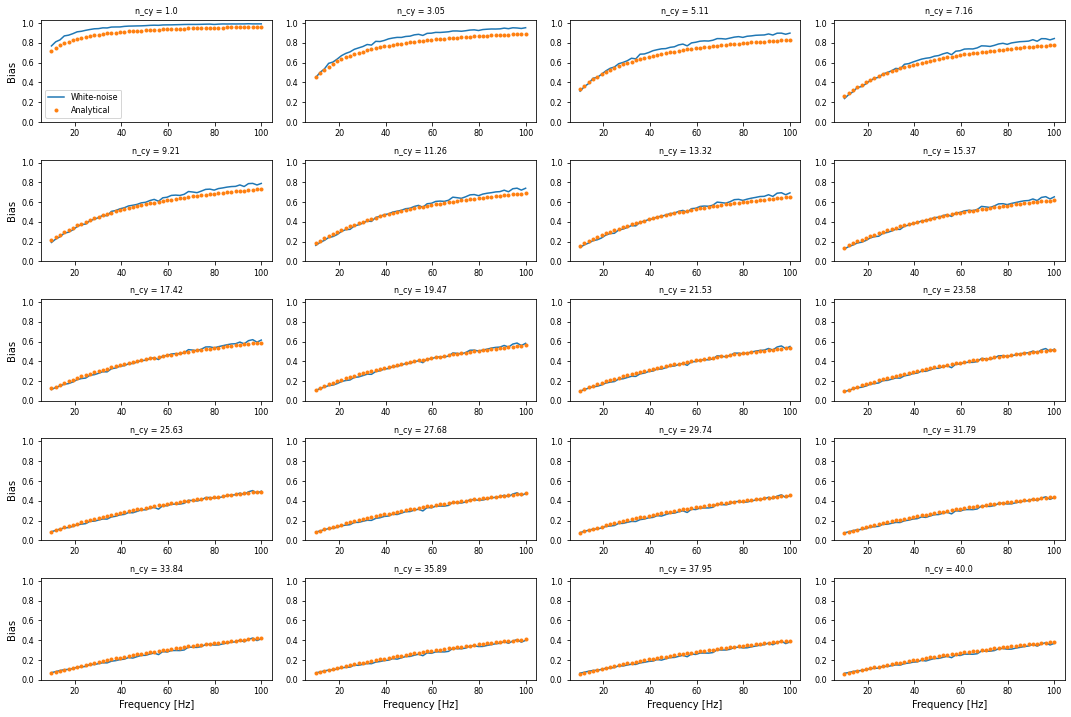

In [140]:
plt.figure(figsize=(15,10))
for i in range( len(n_cy) ):
    plt.subplot(5,4,i+1)
    plt.title(f"n_cy = {np.round(n_cy[i],2)}")
    plt.plot(freqs, B[i], '-')
    #plt.plot(freqs, [B_t[i]]*len(freqs), ".")
    plt.plot(freqs, B_t[i], ".")
    plt.ylim(0,1.03)
    if i==0: plt.legend(["White-noise", "Analytical"])
    if i>15: plt.xlabel("Frequency [Hz]")
    if i%4==0: plt.ylabel("Bias")
plt.tight_layout()

In [146]:
n_cy[5]/freqs

array([1.12631579, 0.95154265, 0.82372349, 0.72617729, 0.64928793,
       0.58712206, 0.53582013, 0.49276316, 0.45611135, 0.42453441,
       0.39704657, 0.37290185, 0.35152531, 0.33246671, 0.31536842,
       0.29994279, 0.28595582, 0.27321522, 0.26156149, 0.25086124,
       0.24100207, 0.23188854, 0.22343916, 0.21558388, 0.20826216,
       0.20142144, 0.19501581, 0.18900505, 0.18335373, 0.17803056,
       0.17300775, 0.16826059, 0.16376698, 0.15950715, 0.15546331,
       0.15161943, 0.14796106, 0.14447506, 0.14114955, 0.13797368,
       0.13493759, 0.13203223, 0.12924935, 0.12658136, 0.12402129,
       0.12156272, 0.11919973, 0.11692685, 0.11473903, 0.11263158])